# Módulo Multiprocessing

En estos apuntes se presentará muy brevemente como ejecutar código en paralelo empleando múltiples procesos.

In [1]:
from time import sleep, time

In [2]:
def delay(num):
    sleep(num)
    return num

Estas celdas sirven para realizar mediciones al vuelo de tiempo. Con la opción `-r` se indican la cantidad de repeticiones y con `-n` el número de interaciones por repetición.

In [3]:
%timeit -r 1 -n 10 delay(1)

1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [4]:
tic = time()
delay(1)
delay(1)
toc = time()
toc - tic

2.2614564895629883

In [5]:
from multiprocessing import Process

Para crear un proceso:

In [6]:
p1 = Process(target=delay,args=(1,))
p2 = Process(target=delay,args=(1,))

Los procesos han sido creados, pero no han sido ejecutados.

In [7]:
p1.start()
p2.start()

Para esperar a que los procesos terminen

In [8]:
p1.join()
p2.join()

Si se junta todo en una celda se puede observar el tiempo total

In [9]:
tic = time()
p1 = Process(target=delay,args=(5,))
p2 = Process(target=delay,args=(5,))
p1.start()
p2.start()
p1.join()
p2.join()
toc = time()
toc - tic

5.027055263519287

Ejecutar los dos procesos en simultáneo toma una cantidad cercana a 5 segundos, y ejecutarlas las funciones en simultáneo hubiera tomado 10 segundos. Sin embargo, el código es poco escalable ¿qué pasaría si se quisiera emplear más de dos procesos en simultáneo? 

In [10]:
# lista de procesos
processes = []
# cantidad de procesos
cp = 4
# empezar a medir el tiempo
tic = time()
# crear una lista de procesos
for _ in range(cp):
    processes.append(Process(target=delay,args=(8,)))
# iniciar los procesos
for p in processes:
    p.start()
# esperar a que terminen los procesos
for p in processes:
    p.join()
# terminar de medir el tiempo
toc = time()
# mostrar tiempo transcurrido
toc - tic

8.12626838684082

Ahora se puede definir una versión multriproceso para la función `delay`

In [11]:
def mpdelay(num,cp):
    processes = []
    for _ in range(cp):
        processes.append(Process(target=delay,args=(num,)))

    for p in processes:
        p.start()

    for p in processes:
        p.join()
    return num

In [12]:
%timeit -r 1 -n 10 mpdelay(4,2)

4.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [13]:
%timeit -r 1 -n 10 mpdelay(4,4)

4.33 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


Al mismo tiempo, el módulo `multiprocessing` proporciona la clase `Pool` la cual crea un objeto que ofrece un medio para paralelizar la ejecución de una función a través de múltiples valores de entrada, distribuyendo los datos de entrada entre los procesos. Esto se ejemplificará por medio la función factorial.

In [14]:
def factorial(n):
    f = 1
    for x in range(1,n+1):
        f *= x
    return f

Por poner un ejemplo, el factorial es una multiplicación de una secuencia de números, para optimizar su tiempo de ejecución usando múltiples procesos se puede dividir esa secuencia en pequeñas subsecuencias y luego multiplicar esos resultados parciales. Para esto vamos a crear dos funciones auxiliares; una para multiplicar una secuencia de números, y otra para multiplicar los elementos de una lista de números no necesariamente secuenciales.

In [15]:
def prodseq(start,stop):
    p = start
    for n in range(start+1,stop+1):
        p *= n
    return p

In [16]:
def prodlist(nums):
    p = 1
    for num in nums:
        p *= num
    return p

In [17]:
from multiprocessing import Pool

In [18]:
def mpfactorial(n,cp):
    # se le indica la cantidad de procesos y se crea el objeto
    p = Pool(cp)
    l1 = [((x*n)//cp)+1 for x in range(cp)]
    l2 = [((x*n)//cp) for x in range(1,cp+1)]
    rp = p.starmap(prodseq, zip(l1,l2))
    p.close()
    p.join()
    return prodlist(rp)

Se realiza una prueba numérica para verificar que el valor es correcto

In [19]:
n = 100000
mpfactorial(n,2) == mpfactorial(n,4) == factorial(n)

True

Podemos realizar una prueba de tiempo al vuelo para tener una idea de como serán los tiempos de ejecución.

In [20]:
%timeit -r 2 -n 10 factorial(n)

1.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [21]:
%timeit -r 2 -n 10 mpfactorial(n,2)

585 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [22]:
%timeit -r 2 -n 10 mpfactorial(n,4)

295 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


# Módulo Concurrent

Otra forma de hacer multiprocessing es con el módulo `concurrent`, cuyo funcionamiento es equivalente, pero nos permite ahorrar bastante código pues la función enviada por el método submit junto con su argumento será puesta en ejecución y se esperará a que termine su ejecución.

In [23]:
import concurrent.futures

In [24]:
from concurrent.futures import ProcessPoolExecutor as executor

In [25]:
f1 = executor().submit(delay,5)
f1.result()

5

Si quisieramos lanzar un proceso extra sería parecido al procedimiento realizado con el módulo multiprocessing

In [26]:
f1 = executor().submit(delay,5)
f2 = executor().submit(delay,5)

In [27]:
f1.result(), f2.result()

(5, 5)

También se puede definir una forma general para una cantidad parametrizada de procesos

In [28]:
def condelay(num,cp):
    res = [executor().submit(delay,num) for _ in range(cp)]
    return [r.result() for r in concurrent.futures.as_completed(res)]

In [29]:
%timeit -r 1 -n 10 condelay(3,4)

3.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


También se puede modificar la función para pasar una lista de números

In [30]:
def condelay(nums):
    res = [executor().submit(delay,num) for num in nums]
    return [r.result() for r in concurrent.futures.as_completed(res)]

In [31]:
%timeit -r 1 -n 10 condelay([1,2,3,4])

4.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


Note que en la implementación anterior se genera un proceso para cada elemento de la lista, y que el tiempo total es cercano al mayor de los tiempos indicados en la lista. Una forma aún más simplicada se puede realizar empleando el método `map`.

In [32]:
def condelay(nums):
    return list(executor().map(delay,nums))

In [33]:
%timeit -r 1 -n 10 condelay([1,2,3,6])

6.72 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


Con una ligera variante respecto de `Pool` también se pueden pasar varios argumentos al método `map`. La diferencia es que en lugar de hacer un `zip` de los dos iterables, se pasan los iterables por separados.

In [34]:
def confactorial(n, cp):
    l1 = [((x*n)//cp)+1 for x in range(cp)]
    l2 = [((x*n)//cp) for x in range(1,cp+1)]
    r = list(executor().map(prodseq, l1, l2))
    return prodlist(r)

Se realiza una prueba numérica para validar el resultado obtenido con 2 y 4 procesos

In [35]:
n = 100000
confactorial(n,2) == confactorial(n,4) == factorial(n)

True

In [36]:
%timeit -r 2 -n 10 factorial(n)

1.78 s ± 21.3 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [37]:
%timeit -r 2 -n 10 confactorial(n,2)

619 ms ± 21.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [38]:
%timeit -r 2 -n 10 confactorial(n,4)

293 ms ± 21.7 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


# Pruebas

In [39]:
import statistics

def filtro_mediana(sign, w):
    signc = []
    lc = sign+sign+sign
    ii = len(sign)
    for i in range(len(sign)):
        izq = i + ii - w//2
        der = i + ii + w//2
        signc.append(statistics.median(lc[izq:der+1]))
    return signc

In [40]:
from statistics import mean

In [41]:
import matplotlib.pyplot as plt

In [42]:
start = 10000
stop = 50000 + start
step = start
tams = range(start,stop,step)
veces = range(20)

In [43]:
ls = []
lmp2 = []
lmp4 = []
lcon2 = []
lcon4 = []
for tam in tams:
    lsi = []
    lmp2i = []
    lmp4i = []
    lcon2i = []
    lcon4i = []
    for _ in veces:
        tic = time()
        rs = factorial(tam)
        toc = time()
        lsi.append(toc-tic)
        
        tic = time()
        rmp2 = mpfactorial(tam,2)
        toc = time()
        lmp2i.append(toc-tic)
        
        tic = time()
        rmp4 = mpfactorial(tam,4)
        toc = time()
        lmp4i.append(toc-tic)
        
        tic = time()
        rcon2 = confactorial(tam,2)
        toc = time()
        lcon2i.append(toc-tic)
        
        tic = time()
        rcon4 = confactorial(tam,4)
        toc = time()
        lcon4i.append(toc-tic)
        
    ls.append(mean(filtro_mediana(lsi,7)))
    lmp2.append(mean(filtro_mediana(lmp2i,7)))
    lmp4.append(mean(filtro_mediana(lmp4i,7)))
    lcon2.append(mean(filtro_mediana(lcon2i,7)))
    lcon4.append(mean(filtro_mediana(lcon4i,7)))

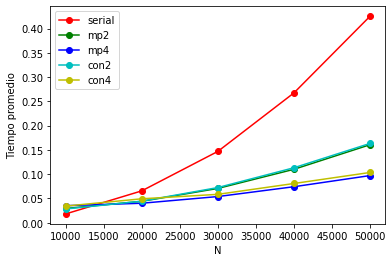

In [44]:
plt.plot(tams,ls,'r-o',label='serial')
plt.plot(tams,lmp2,'g-o',label='mp2')
plt.plot(tams,lmp4,'b-o',label='mp4')
plt.plot(tams,lcon2,'c-o',label='con2')
plt.plot(tams,lcon4,'y-o',label='con4')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

Se observa que para el primer caso todas las formas con múltiples procesos presentaron tiempos menores a la forma serial, y luego recién a partir del segundo tamagno se empieza a observar ganancia.

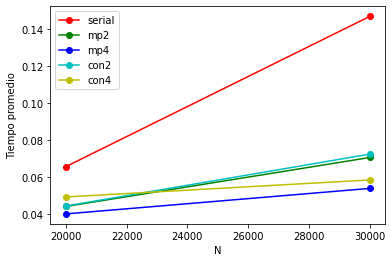

In [45]:
plt.plot(tams[1:3],ls[1:3],'r-o',label='serial')
plt.plot(tams[1:3],lmp2[1:3],'g-o',label='mp2')
plt.plot(tams[1:3],lmp4[1:3],'b-o',label='mp4')
plt.plot(tams[1:3],lcon2[1:3],'c-o',label='con2')
plt.plot(tams[1:3],lcon4[1:3],'y-o',label='con4')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

También se observó en la primera gráfica que los casos para igual cantidad de procesos tienen curvas muy cercanas en valores. Por eso se les realizará una gráfica aislada a cada correspondencia.

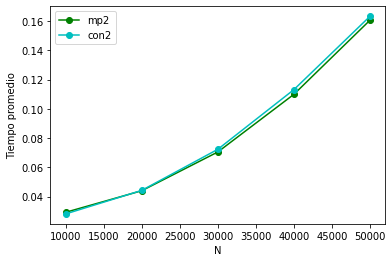

In [46]:
plt.plot(tams,lmp2,'g-o',label='mp2')
plt.plot(tams,lcon2,'c-o',label='con2')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

Con dos procesos no parece haber diferencia sustancial entre ambos módulos.

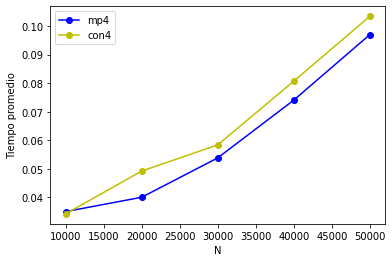

In [47]:
plt.plot(tams,lmp4,'b-o',label='mp4')
plt.plot(tams,lcon4,'y-o',label='con4')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

Con cuatro procesos ya se aprecia una ligera distancia, siendo el módulo `multiprocessing` el que brinda un mejor resultado en tiempo. Ahora se procederá a calcular el _speedup_, con el tiempo serial como referencia.

In [48]:
from numpy import asarray

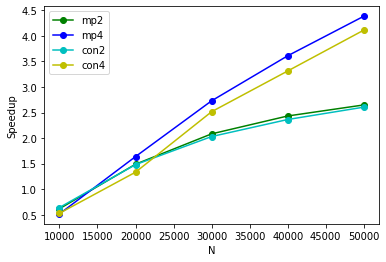

In [49]:
plt.plot(tams,asarray(ls)/asarray(lmp2),'g-o',label='mp2')
plt.plot(tams,asarray(ls)/asarray(lmp4),'b-o',label='mp4')
plt.plot(tams,asarray(ls)/asarray(lcon2),'c-o',label='con2')
plt.plot(tams,asarray(ls)/asarray(lcon4),'y-o',label='con4')
plt.xlabel('N')
plt.ylabel('Speedup')
plt.legend()

En línea con las observaciones anteriores, en el primer caso, la gráfica muestra que todos presentan pérdidas en tiempo de ejecución, y a partir del segundo caso todos presentan ganancia.

Como comentario, solo mencionar que el uso de múltiples procesos se recomienda solo en casos de una aplicación que esté limitada por CPU, y que requiera mucha computación. Por otro lado, la cantidad de procesos que puede lanzar no está limitada, pero se recomienda que no exceda a la cantidad de núcleos que posee su ordenador.

In [50]:
from multiprocessing import cpu_count

In [51]:
cpu_count()

4

Se recomienda al lector realizar mediciones con una cantidad de procesos mayor a la cantidad de CPUs y comentar las observaciones.